<a href="https://colab.research.google.com/github/GioAcosta1/Proyecto_Final_Cancer_de_Piel/blob/Dayana/Copia_Dayana_DETECCION_Y_CLASIFICACION_DE_CANCER_DE_PIEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Montaje de drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Ordenamiento de las imágenes**

In [4]:
#Descomprimir base de datos de imágenes
import io
import zipfile
import os
import glob


!unzip "/content/drive/MyDrive/Deep learning/PF_Cancer_piel/DATASET.zip" -d "/content/drive/MyDrive/Deep Learning/PF_Cancer_piel/DATASET"

Archive:  /content/drive/MyDrive/Deep learning/PF_Cancer_piel/DATASET.zip
checkdir:  cannot create extraction directory: /content/drive/MyDrive/Deep Learning/PF_Cancer_piel/DATASET
           No such file or directory


In [5]:
#Librerias a utilizar
import pandas as pd
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from PIL import Image

from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.metrics import confusion_matrix

In [6]:
#Lectura de metadata

data_skin = pd.read_csv('/content/drive/MyDrive/Deep learning/PF_Cancer_piel/HAM10000_metadata.csv')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


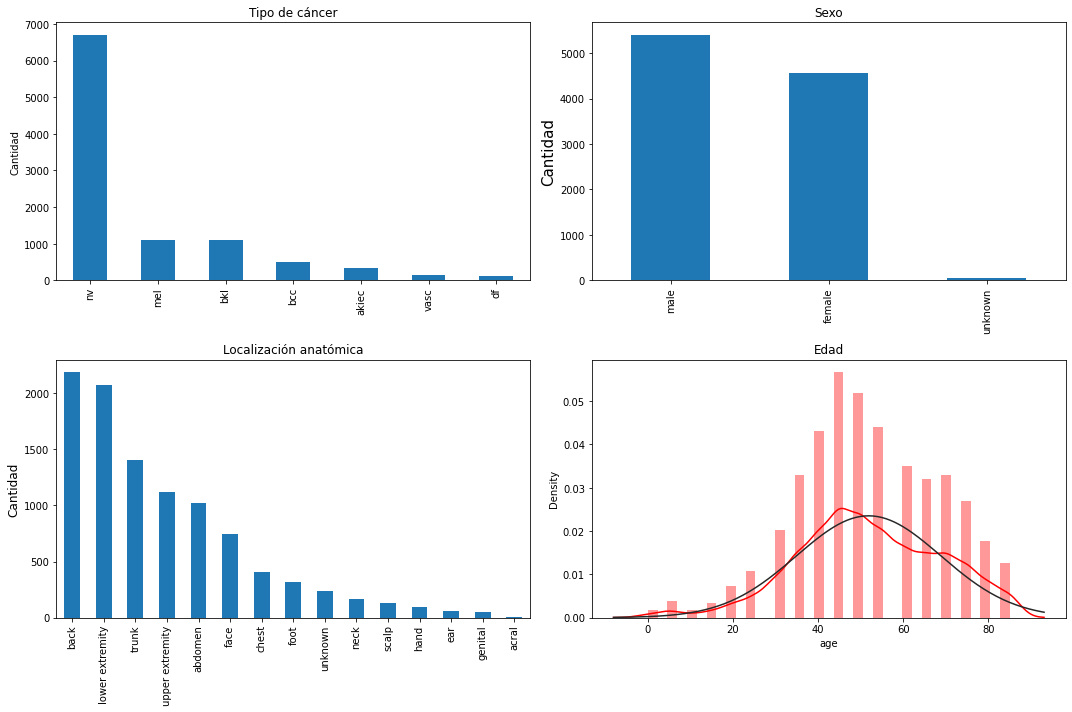

In [7]:
#Ver la distribución de los datos
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
data_skin['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Cantidad')
ax1.set_title('Tipo de cáncer');

ax2 = fig.add_subplot(222)
data_skin['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Cantidad', size=15)
ax2.set_title('Sexo');

ax3 = fig.add_subplot(223)
data_skin['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Cantidad',size=12)
ax3.set_title('Localización anatómica')

ax4 = fig.add_subplot(224)
sample_age = data_skin[pd.notnull(data_skin['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Edad')

plt.tight_layout()
plt.show()

In [8]:
#Etiquetado

l_encode = LabelEncoder()
l_encode.fit(data_skin['dx'])
LabelEncoder()
print(list(l_encode.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [9]:
data_skin['label'] = l_encode.transform(data_skin['dx'])
print(data_skin.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
8162  HAM_0003099  ISIC_0025734   nv      histo  25.0    male   
4738  HAM_0004123  ISIC_0032216   nv  follow_up  45.0    male   
694   HAM_0000881  ISIC_0028404  bkl      histo  80.0    male   
8021  HAM_0006295  ISIC_0033086   nv      histo  25.0  female   
5318  HAM_0006933  ISIC_0027594   nv  follow_up  45.0    male   
5670  HAM_0003070  ISIC_0032323   nv  follow_up  50.0    male   
4723  HAM_0002396  ISIC_0026025   nv  follow_up  50.0    male   
3172  HAM_0001049  ISIC_0027703   nv  follow_up  50.0  female   
5718  HAM_0003342  ISIC_0027726   nv  follow_up  60.0    male   
4048  HAM_0004540  ISIC_0027357   nv  follow_up  50.0    male   

         localization  label  
8162             back      5  
4738            trunk      5  
694   lower extremity      2  
8021             back      5  
5318             back      5  
5670            trunk      5  
4723          abdomen      5  
3172            trunk      5  
5718 

In [10]:
df_type_0 = data_skin[data_skin['dx']=='akiec']
df_type_1 = data_skin[data_skin['dx']=='bcc']
df_type_2 = data_skin[data_skin['dx']=='bkl']
df_type_3 = data_skin[data_skin['dx']=='df']
df_type_4 = data_skin[data_skin['dx']=='mel']
df_type_5 = data_skin[data_skin['dx']=='nv']
df_type_6 = data_skin[data_skin['dx']=='vasc']

len(df_type_2)

1099

In [11]:
print(data_skin['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [12]:
#Balancear base de datos

from sklearn.utils import resample

df_type_0_bal = resample(df_type_0, replace=True, n_samples = 400, random_state=42)
df_type_1_bal = resample(df_type_1, replace=True, n_samples = 400, random_state=42)
df_type_2_bal = resample(df_type_2, replace=True, n_samples = 400, random_state=42)
df_type_3_bal = resample(df_type_3, replace=True, n_samples = 400, random_state=42)
df_type_4_bal = resample(df_type_4, replace=True, n_samples = 400, random_state=42)
df_type_5_bal = resample(df_type_5, replace=True, n_samples = 400, random_state=42)
df_type_6_bal = resample(df_type_6, replace=True, n_samples = 400, random_state=42)

data_skin_bal = pd.concat([df_type_0_bal, df_type_1_bal, df_type_2_bal,
                           df_type_3_bal, df_type_4_bal, df_type_5_bal,
                           df_type_6_bal])

In [13]:
import glob
image_path = glob.glob('/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Orgaizacion_data/Clases/**/*.jpg')

In [14]:
os.mkdir('/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Total_HAM/akiec/')
os.mkdir('/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Total_HAM/bcc/')
os.mkdir('/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Total_HAM/bkl/')
os.mkdir('/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Total_HAM/df/')
os.mkdir('/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Total_HAM/mel/')
os.mkdir('/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Total_HAM/nv/')
os.mkdir('/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Total_HAM/vasc/')

In [15]:
for id in data_skin_bal['image_id']:
  find_path = [s for s in image_path if id in s]
  for path in find_path:
    p = path.split('/')
    if 'akiec' in p:
      shutil.copy(path,'/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Total_HAM/akiec/')
    elif 'bcc' in p:
      shutil.copy(path,'/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Total_HAM/bcc/')
    elif 'bkl' in p:
      shutil.copy(path,'/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Total_HAM/bkl/')
    elif 'df' in p:
      shutil.copy(path,'/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Total_HAM/df/')
    elif 'mel' in p:
      shutil.copy(path,'/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Total_HAM/mel/')
    elif 'nv' in p:
      shutil.copy(path,'/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Total_HAM/nv/')
    elif 'vasc' in p:
      shutil.copy(path,'/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Total_HAM/vasc/') 



In [17]:
arc_akiec = os.listdir('/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Total_HAM/bcc/')
len(arc_akiec)

0

# **Creación de Data Generator**

In [18]:
data_generator = ImageDataGenerator(validation_split = 0.15)

In [19]:
path_classes = '/content/drive/MyDrive/Deep learning/PF_Cancer_piel/Organizacion_data/Clases/'
train_image_generator = data_generator.flow_from_directory(
    directory = path_classes,
    class_mode = 'categorical',
    batch_size = 16,
    target_size = (64,64),
    subset = 'training'
)
val_image_generator = data_generator.flow_from_directory(
    directory = path_classes,
    class_mode = 'categorical',
    batch_size = 16,
    target_size = (64, 64),
    subset = 'validation'
)

Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


IndexError: ignored

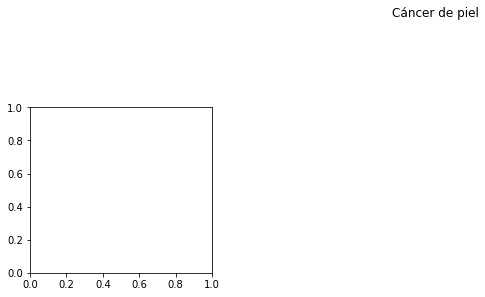

In [21]:
x, y = next(train_image_generator)
classes = train_image_generator.class_indices
fig = plt.figure(figsize=(15,14))
fig.suptitle('Cáncer de piel')
for i in range(0, 16):
  plt.subplot(4,4,i+1)
  image = x[i].astype(int)
  y_search = y[i,:]
  idx = list(np.where(y_search==1))
  n_type = list(classes.keys())[list(classes.values()).index(idx[0])]
  fig.add_subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(n_type)
  plt.xticks([])
  plt.yticks([])
  n_type = ''

# **Definición de red neuronal convolucional**

In [22]:
n_classes = 7

model = Sequential()
model.add(Conv2D(256, (3,3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2,2,)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2,)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2,)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation = 'softmax'))
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)       0

# **Entrenamiento de la red neuronal convolucional**

In [23]:
num_epochs = 100
history = model.fit(
    train_image_generator,
    steps_per_epoch = train_image_generator.samples//train_image_generator.batch_size,
    validation_data = val_image_generator,
    validation_steps = val_image_generator.samples // val_image_generator.batch_size,
    epochs = num_epochs)

ValueError: ignored

In [24]:
#score = model.evaluate(x_test, y_test)
#print('Test accuracy:', score[1])

In [26]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: ignored

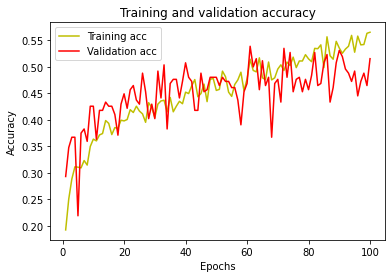

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
image_test = Image.open('/content/melanoma.jpg')
image_test_resize = image_test.resize((32,32))

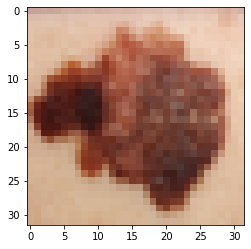

In [ ]:
plt.imshow(image_test_resize)

In [ ]:
image_test_resize = np.array(image_test_resize)
nn = image_test_resize.reshape(1,32,32,3)

pred = model.predict(nn)
print(pred)
pred_class = np.argmax(pred, axis=1)

1/1 [==============================] - 0s 24ms/step
[[1.7193703e-02 1.4434011e-03 5.2206405e-02 6.9435919e-04 7.5322223e-01
  1.7518704e-01 5.2806809e-05]]


4